# Classificação de dígitos da American Sign Language
Aluno: Daniel Ferreira Abadi<br>
Matrícula: 2018088062<br>
Link da apresentação: https://youtu.be/7oawXU_xR2s

Como trabalho final da matéria de Aprendizado de Máquina, foi escolhido um conjunto de dados que contém as representações dos dígitos de 0 a 9 da American Sign Language. Neste conjunto de dados há cerca de 2 mil imagens, com a distribuição uniforme de 200 de cada sinal, onde as mãos estão em posições parecidas nas imagens e com o mesmo fundo. Todas as imagens possuem o mesmo tamanho, 100x100 pixels, contendo mãos de mais de 200 pessoas e estão disponíveis em https://github.com/ardamavi/Sign-Language-Digits-Dataset.

Este tema foi escolhido pois tenho interesse em aprender Libras, a Linguagem de Sinais Brasileira, que é diferente da American Sign Language e das outras espalhadas pelo mundo. Como não havia nenhum conjunto de dados parecido usando Libras, considerei que fosse um bom início, principalmente por ter tantos dados.

Libras é uma língua de modalidade gestual-visual, reproduzida através de gestos, expressões faciais e corporais, possuindo um alfabeto e estrutura linguística e gramatical própria. No país, cerca de 5% da população é surda e, parte dela usa a Libras como auxílio para comunicação. De acordo com dados do IBGE, esse número representa 10 milhões de pessoas, sendo que 2,7 milhões não ouvem nada.

Como nem todas as pessoas surdas sabem Libras, imagine o percentual de pessoas que não são surdas e sabem essa linguagem. A barreira de comunicação imposta a essas pessoas é tão grande que tira tanto sua autonomia quanto liberdade para fazer coisas simples, como ir a padaria e estudar. Este trabalho, portanto, pode ser visto como um pontapé inicial na tentativa de desenvolver alguma tecnlogia que possa traduzir linguagens de sinais para o Português. Lembrando que existe um aplicativo de telefone muito bom, ele é chamado de Hand Talk, e traduz do Português para Libras.

Fonte:<br> https://g1.globo.com/rj/sul-do-rio-costa-verde/especial-publicitario/ubm/conhecimento-transforma/noticia/2020/02/12/populacao-brasileira-e-composta-por-mais-de-10-milhoes-de-pessoas-surdas.ghtml



In [ ]:
from IPython.display import clear_output

!pip install tensorflow
!pip install opencv-python

clear_output()

## Importações necessárias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import os

from tensorflow import keras

from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from skimage.feature import hog
from sklearn.model_selection import train_test_split
np.random.seed(42)

## Carregamento do conjunto de dados

Todas as imagens são carregadas juntamente com a criação dos seus labels, cada uma é colocada em escala de cinza, para baratear o processo de classificação. Durante o treinamento, foi notado que algumas imagens não estavam no tamamnho correto, três para ser mais específico, e essas foram desconsideradas. Com a finalidade de diminuir erros de representação por overflow, todos os valores das imagens foram divididos por 255, normalizando os valores. Há a opção de se carregar o conjunto de dados sem passar para a escala de cinza e sem a normalização dos valores, e essa opção foi utilizada nos testes com a ResNet 50, como veremos abaixo.

Para o carregamento dos conjuntos de dados é necessário que o conteúdo esteja na mesma pasta que o notebook, do mesmo modo que foi baixado e extraído da fonte. Então teremos duas pastas, uma chamada Dataset, com 10 pastas dentro, e outra chamada Examples com 10 imagens dentro.

In [ ]:
def get_images(caminho, gray_scale = True):
    set_images = []
    set_labels = []
    for num_set in range(0, 10):
        for i, img_file in enumerate(os.listdir(caminho + "/" + str(num_set) + "/")):
            img = cv2.imread(caminho + "/" + str(num_set) + "/" + img_file)
            if gray_scale:
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                if img_gray.shape == (100, 100):
                    img_gray = img_gray.astype('float32')
                    img_gray /= 255
                    set_images.append(img_gray)
                    set_labels.append(num_set)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                if img.shape == (100, 100, 3):
                    img = img.astype('float32')
                    set_images.append(img)
                    set_labels.append(num_set)
    return set_images, set_labels

set_images, set_labels = get_images("Dataset")

Aqui temos uma amostra do conjunto de dados, os números estão em ordem crescente. A primeira imagem se refere ao número 0 e segue até o número 9, podemos notar que são mãos de pessoas diferentes, tendo cores diferentes e algumas até possuem esmalte. Um ponto importante é que todas possuem o mesmo fundo e são o único objeto presente, deixando o problema mais simples.

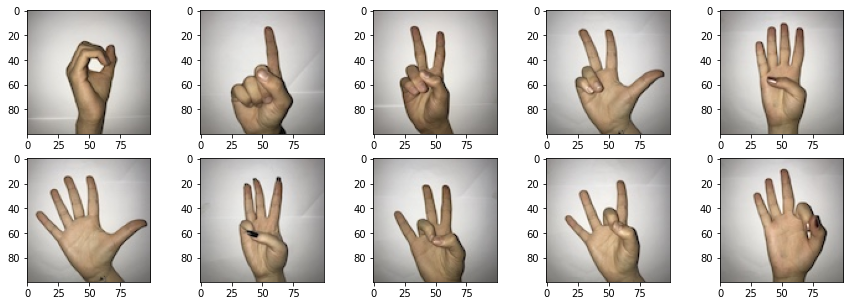

In [ ]:
def carrega_exemplos():
    exemplos = [[], [], [], [], [], [], [], [], [], []]
    for i, img_file in enumerate(os.listdir("Examples")):
        img = cv2.imread("Examples/" + img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        num_img = int(img_file.split('_')[1].split('.')[0])
        exemplos[num_img] = img
    return exemplos
    
exemplos = carrega_exemplos()

f, axarr = plt.subplots(2,5, figsize=(15,5))
img = 0
for i in range(0, 2):
    for j in range(0, 5):
        axarr[i,j].imshow(exemplos[img])
        img += 1

## Funções auxiliares

Para podermos usar a rede convolucional proposta é necessário converter os labels para one-hot enconding, para que a rede possa usar uma função de ativação softmax para dar as probabilidades de cada imagem ser um número. Para isso, portanto, foram criadas duas funções para auxiliar nessa mudança de label para one-hot.

In [ ]:
def convert_labels_onehot(dataset):
    for i in range(len(dataset)):
        onehot = np.zeros(10)
        onehot[dataset[i]] = 1
        dataset[i] = onehot

def convert_onehot_labels(data):
    idx = np.argmax(data)
    return idx

Como parte do trabalho era verificar e procurar melhores modelos para tentar resolver nosso problema, a função abaixo foi criada para comparar visualmente a acurácia de alguns modelos tradicionais utilizados como teste, como veremos abaixo.

In [ ]:
def plot_charts(x_axis, y_axis, x_label, title, limit):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_ylim([limit, 1])
    ax.set_ylabel("Acurácia")
    ax.set_xlabel(x_label)
    colors = ["green" if y ==  max(y_axis) else "gray" for y in y_axis]
    ax.bar(x_axis, y_axis, color=colors)
    ax.grid(True, axis='y', color="gray")
    plt.plot()

A função abaixo é para apenas auxiliar no plot da matriz de confusão dos resultados provenientes da rede convolucional proposta e da ResNet50 com fine-tune.

In [ ]:
def plot_confusion(preds, y_test):
    matrix = confusion_matrix(preds, y_test)
    df_cm = pd.DataFrame(matrix, index = [i for i in "0123456789"], columns = [i for i in "0123456789"])
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    fig, ax = plt.subplots(figsize=(10,7))
    disp.plot(ax=ax)

## Tratamento dos dados

Na célula abaixo dividimos o conjunto de dados em treino e validação com a ajuda do método train_test_split, tendo um conjunto de treino de 60%, fazendo com que a divisão seja estratificada, gerando uma divisão uniforme entre as classes. Isso ajuda nos métodos de classificação, pois garante que não haverá nenhuma classe desbalanceada em nenhum dos conjuntos.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(set_images, set_labels, random_state=1, test_size=0.4, stratify=set_labels)

O trecho de código abaixo possui um tratamento para que possamos utilizar os dados nos modelos tradicionais. Cada imagem do conjunto de treino tem suas features extraídas, cerca de 4350 features, e são adicionadas a um novo conjunto.

In [ ]:
y_treino_features = []
for i in range(len(y_train)):
    y_treino_features.append(y_train[i])

X_treino_features = []
for i in range(len(X_train)):
    fd, _ = hog(X_train[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    X_treino_features.append(fd)

X_teste_features = []
for i in range(len(X_test)):
    fd, _ = hog(X_test[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    X_teste_features.append(fd)

y_teste_features = []
for i in range(len(y_test)):
    y_teste_features.append(y_test[i])

Para que possamos utilizar da melhor forma os dados no treinamento da CNN proposta, o conjunto de teste criado foi dividido em teste e validação, cada um possuindo cerca de 20% do total inicial, 412 imagens para cada.

In [ ]:
X_validation = X_test[412:].copy()
y_validation = y_test[412:].copy()

X_test = X_test[:412].copy()
y_test = y_test[:412].copy()

convert_labels_onehot(y_train)
convert_labels_onehot(y_validation)

X_train = np.array(X_train)
y_train = np.array(y_train) 

X_validation = np.array(X_validation)
y_validation = np.array(y_validation) 

X_test = np.array(X_test)

## Teste usando modelos tradicionais
 

Assim como na trabalho prático 1 da matéria, vamos testar alguns dos algoritmos clássicos, como Naive Bayes, SVM, KNN e Random Forest, mudando algum de seus hiperparâmetros. A avaliação de cada algoritmo foi feita utilizando a validação cruzada 5-fold, juntamente com a variação dos hiperparâmetros, que foi feita utilizando a função GridSearchCV, com "scoring" sendo medido em acurácia.

### Naive Bayes 

In [ ]:
gnb = GaussianNB()
gnb_searcher = GridSearchCV(gnb, {}, scoring="accuracy", verbose=3, n_jobs=1, cv=5)
gnb_searcher.fit(X_treino_features, y_treino_features)

print(f"Acurácia = {gnb_searcher.cv_results_['mean_test_score'][0]}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.721 total time=   0.2s
[CV 2/5] END ..................................., score=0.713 total time=   0.1s
[CV 3/5] END ..................................., score=0.729 total time=   0.1s
[CV 4/5] END ..................................., score=0.696 total time=   0.1s
[CV 5/5] END ..................................., score=0.745 total time=   0.1s
Acurácia = 0.7206477732793521


O algoritmo Naive Bayes, assim como no primeiro trabalho, foi utilizado apenas como uma base para o experimento, mostrando que os dados são mais difícieis de classificar do que os do primeiro trabalho.

### SVM

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Resultados:
Melhor acurária = 0.8947368421052632
Melhor parâmetro = kernel: poly



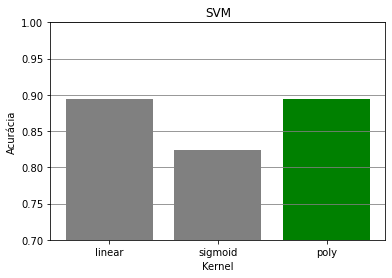

In [ ]:
svm_classifier = svm.SVC(probability=True)
svm_kernels = {"kernel": ["linear", "sigmoid", "poly"]}
svm_searcher = GridSearchCV(svm_classifier, svm_kernels, scoring="accuracy", verbose=3, n_jobs=-1, cv=5)
svm_searcher.fit(X_treino_features, y_treino_features)

print(f"Resultados:")
print(f"Melhor acurária = {svm_searcher.best_score_}")
print(f"Melhor parâmetro = {', '.join('{}: {}'.format(k, v) for k, v in svm_searcher.best_params_.items())}\n")
plot_charts(svm_kernels['kernel'], svm_searcher.cv_results_["mean_test_score"], 'Kernel', 'SVM', 0.7)

O objetivo deste experimento era verificar o quão bem cada um dos kernels do SVM classifica as imagens utilizando um extrator de features. Podemos notar que o polinomial, com seus valores padrão, foi o que se saiu melhor, tendo quase 90% de acurácia. Também é interessante mencionar que o kernel linear teve um resultado próximo, mostrando que o problema não é tão complicado, mas ainda sim não possui resultados satisfatórios.

### KNN

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Resultados:
Melhor acurária = 0.7684210526315789
Melhor parâmetro = n_neighbors: 16



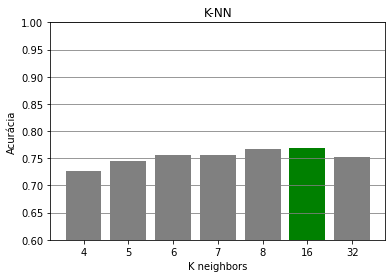

In [ ]:
knn_classifier = KNeighborsClassifier()
num_neighbors = {'n_neighbors': [4, 5, 6, 7, 8, 16, 32]}
knn_searcher = GridSearchCV(knn_classifier, num_neighbors, scoring="accuracy", verbose=3, n_jobs=-1, cv=5)
knn_searcher.fit(X_treino_features, y_treino_features)

print(f"Resultados:")
print(f"Melhor acurária = {knn_searcher.best_score_}")
print(f"Melhor parâmetro = {', '.join('{}: {}'.format(k, v) for k, v in knn_searcher.best_params_.items())}\n")
plot_charts(['4', '5', '6', '7', '8', '16', '32'], knn_searcher.cv_results_["mean_test_score"], 'K neighbors', 'K-NN', 0.6)

O algoritmo KNN não apresentou bons resultados, ficando parecido com o Naive Bayes. Mesmo variando bastante o número de vizinhos escolhidos, a acurácia não chegou a 80% nos testes, mostrando que os dados não são bem classificáveis olhando as features mais próximas. Um fator importante a ser observado é que dependendo das features utilizadas, este algoritmo é um dos que apresentam maior variação nos resultados.

### Random Forest

Resultados:
Melhor acurária = 0.822672064777328
Melhor parâmetro = n_estimators: 100



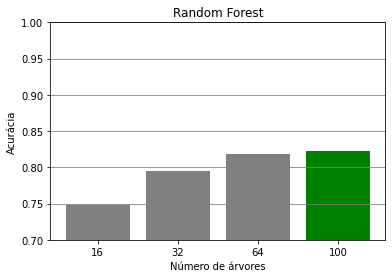

In [ ]:
forest_classifier = RandomForestClassifier()
num_estimators = {"n_estimators": [16, 32, 64, 100]}
forest_searcher = GridSearchCV(forest_classifier, num_estimators, scoring="accuracy", verbose=3, n_jobs=-1, cv=5)
forest_searcher.fit(X_treino_features, y_treino_features)

print(f"Resultados:")
print(f"Melhor acurária = {forest_searcher.best_score_}")
print(f"Melhor parâmetro = {', '.join('{}: {}'.format(k, v) for k, v in forest_searcher.best_params_.items())}\n")
plot_charts(['16', '32', '64', '100'], forest_searcher.cv_results_["mean_test_score"], 'Número de árvores', 'Random Forest', 0.7)

Para o Random Forest, apenas o número de árvores foi alterado, deixando os outros hiperparâmetros das árvores geradas como padrão, isso nos leva a ter árvores com tamanhos máximos indefinidos. Neste teste foram utilizadas poucas árvores em virtude da quantidade de features geradas, levando um longo tempo de execução. O melhor resultado foi alcançado com 100 árvores, chegando a 82% de acurácia.

### Comparação


Como pudemos observar, os modelos mais tradicionais não atingem acurácia maior que 90% utilizando um extrator de features. Esse extrator em questão tem como resultado um conjunto de 4356 features, estas que são passadas como dados de treino e teste para os classificadores acima. O SVM com kernel polinomial foi o que mostrou melhor resultado, chegando em 89% de acurácia. É importante evidenciar o quanto a extração de features impacta no resultado dos algoritmos, em testes feitos com features diferentes o resultado variou muito, sendo escolhido o melhor conjunto de features, em termos de acurácia, encontrado. O desafio, portanto, é criar uma arquitetura de rede neural convolucional que supere estes resultados.

## Rede proposta

Para resolver o problema acima foi decidido criar uma Rede Neural Convolucional, essa escolha foi feita com base no tipo de dado a ser utilizado, as imagens. Para criar a rede, será utilizada a biblioteca Keras, que funciona como uma interface da biblioteca TensorFlow. Inicialmente temos apenas uma camada de entrada que espera elementos de dimensões 100x100x1. Ou seja, as imagens carregadas em escala de cinza.

In [ ]:
input = keras.layers.Input(shape=(100, 100, 1))

A parte convolucional da rede é composta por 4 camadas de convolução e pooling, todas as camadas de convolução utilizam um kernel 3x3, a ReLU como função de ativação e o padding 'same', para que mantêssemos o tamanho dos mapas de ativação. Já as camadas de pooling são todas maxpooling, que pega os valores utilizando janelas 2x2, pulando de 2 em 2, servindo tanto para sumarizar informações importantes dos mapas de ativação quanto para introduzir generalização nestes. As camadas de convolução vão aumentando o número de filtros conforme a potência de 2, sendo 32, 64, 128 e 256, e esses valores e quantidades de camadas foram definidos de forma empírica, onde foi buscado uma maior acurácia.

In [ ]:
conv1 = keras.layers.Conv2D(filters=32, kernel_size=[3,3], activation='relu', padding='same')(input)
pooling1 = keras.layers.MaxPooling2D((2, 2), strides=2, padding='same')(conv1)

conv2 = keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu', padding='same')(pooling1)
pooling2 = keras.layers.MaxPooling2D((2, 2), strides=2, padding='same')(conv2)

conv3 = keras.layers.Conv2D(filters=128, kernel_size=[3,3], activation='relu', padding='same')(pooling2)
pooling3 = keras.layers.MaxPooling2D((2, 2), strides=2, padding='same')(conv3)

conv4 = keras.layers.Conv2D(filters=256, kernel_size=[3,3], activation='relu', padding='same')(pooling3)
pooling4 = keras.layers.MaxPooling2D((2, 2), strides=2, padding='same')(conv4)

A saída da parte convolucional é tratada para que possa ser utilizada pela rede densa, para isso essa saída passa por uma camada 'flat', que transforma a saída para a entrada de forma linear. Agora temos 3 camadas de rede densa que vão diminuindo o número de neurônios, 64, 64, 16, cujos números e quantidades de camadas foram atingidos com base em testes. Entre as camadas densas, há um dropout de 20%, que foi utilizado para que a rede aprendesse features mais robustas, novamente a quantidade de camadas e o percentual de dropout foram definidos de forma empírica. A camada final possui 10 saídas, sendo cada uma delas a probabilidade da imagem em questão fazer parte de cada uma delas, essas probabilidades são adquiridas utilizando-se a função de ativação softmax.

In [ ]:
flat = keras.layers.Flatten()(pooling4)

dense0 = keras.layers.Dense(units=64)(flat)
drop0 = keras.layers.Dropout(.2)(dense0)

dense1 = keras.layers.Dense(units=64)(drop0)
drop1 = keras.layers.Dropout(.2)(dense1)

dense2 = keras.layers.Dense(units=16)(drop1)
drop2 = keras.layers.Dropout(.2)(dense2)

dense3 = keras.layers.Dense(units=16)(drop2)
output = keras.layers.Dense(units=10, activation=keras.activations.softmax)(dense3)

final_model = keras.Model(input, output)

final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856 

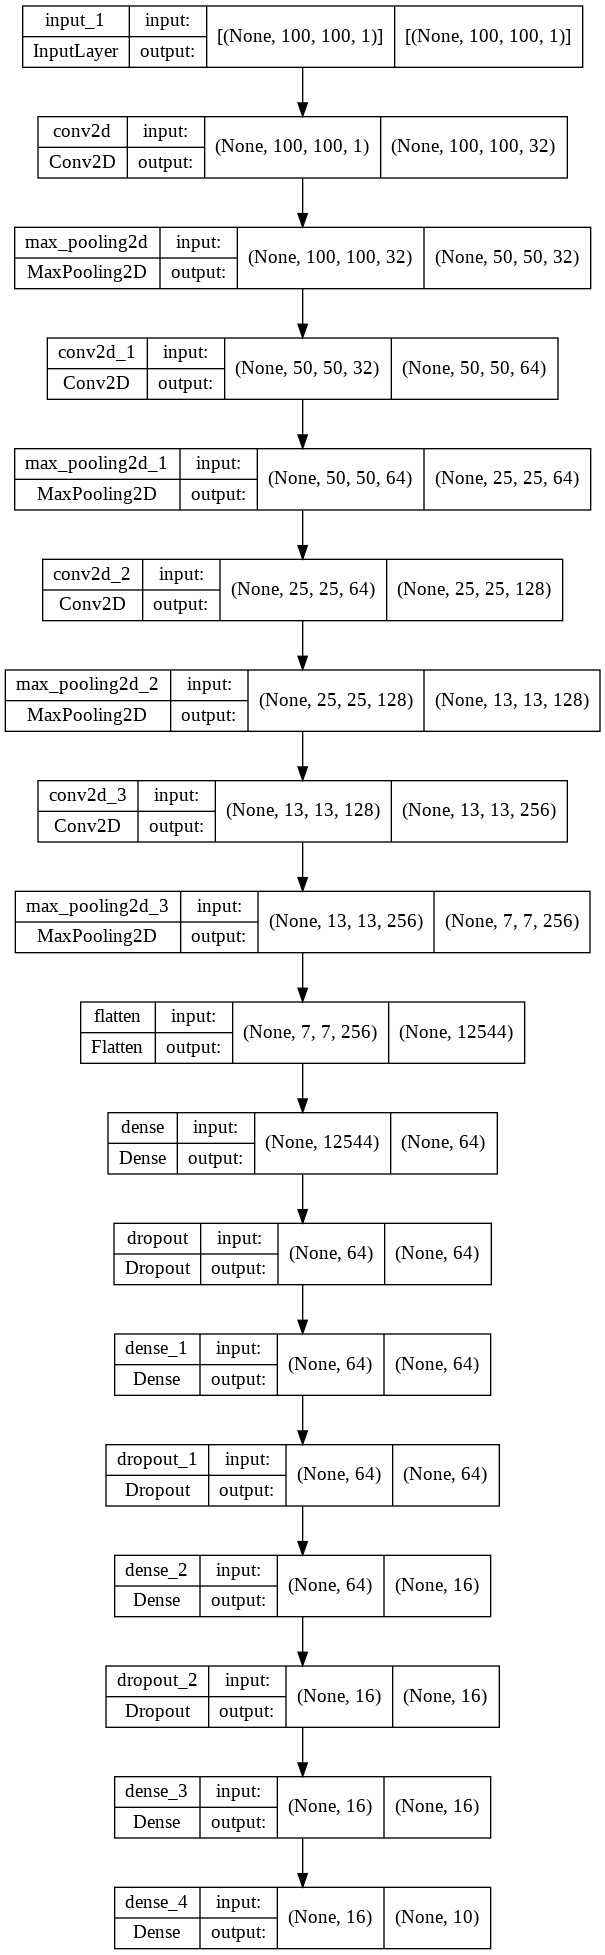

In [ ]:
keras.utils.plot_model(final_model, show_shapes=True)

Na célula abaixo ocorre apenas o treinamento da rede, onde temos 9 épocas, com batch de tamanho 25, cuja métrica é a acurácia. Tanto o número de épocas quanto o tamanho do batch foram definidos de maneira empírica, juntamente com o conhecimento adquirido durante a matéria.

In [ ]:
keras.backend.clear_session()
optimizer = keras.optimizers.Adam(0.001)
loss_fn = keras.losses.CategoricalCrossentropy()

final_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
EPOCHS = 9

validation_data = (X_validation, y_validation)
history = final_model.fit(x=X_train, y=y_train, epochs=EPOCHS, batch_size=25, validation_data=validation_data, verbose=1)

Epoch 1/9
50/50 [==============================] - 31s 600ms/step - loss: 2.3101 - accuracy: 0.1004 - val_loss: 2.2939 - val_accuracy: 0.2112
Epoch 2/9
50/50 [==============================] - 31s 624ms/step - loss: 1.9725 - accuracy: 0.2559 - val_loss: 1.4974 - val_accuracy: 0.5024
Epoch 3/9
50/50 [==============================] - 32s 638ms/step - loss: 1.3169 - accuracy: 0.5077 - val_loss: 0.8552 - val_accuracy: 0.6893
Epoch 4/9
50/50 [==============================] - 30s 599ms/step - loss: 0.7207 - accuracy: 0.7530 - val_loss: 0.4342 - val_accuracy: 0.8762
Epoch 5/9
50/50 [==============================] - 30s 610ms/step - loss: 0.5119 - accuracy: 0.8316 - val_loss: 0.3413 - val_accuracy: 0.9005
Epoch 6/9
50/50 [==============================] - 30s 601ms/step - loss: 0.2913 - accuracy: 0.9134 - val_loss: 0.2795 - val_accuracy: 0.9223
Epoch 7/9
50/50 [==============================] - 30s 602ms/step - loss: 0.2801 - accuracy: 0.9077 - val_loss: 0.2469 - val_accuracy: 0.9320
Epoch 

Podemos observar, a partir dos gráficos abaixo, que os valores das acurácias e da perda do treinamento e da validação convergem para valores bem similares com o passar das épocas. Esse é um bom sinal de que o número de épocas e arquitetura da rede foi bem escolhido, já que não há indicíos de overfitting e de underfitting.

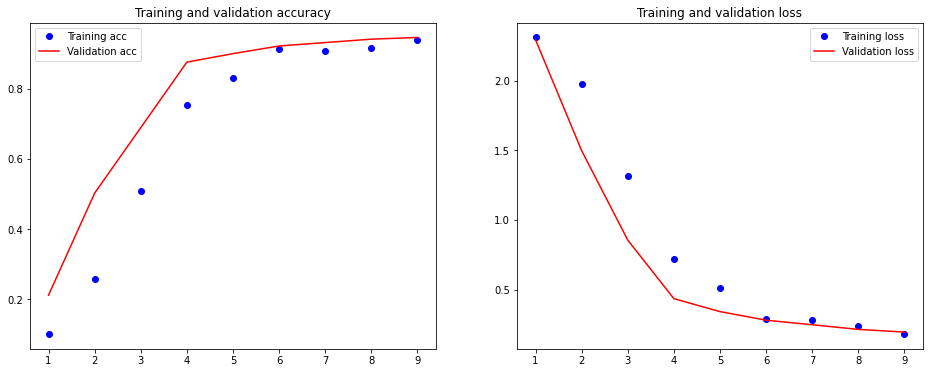

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'r', label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.legend()
ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()
plt.show()

Na saída da célula abaixo, temos as precisões, revocações e f1-score de cada classe. Podemos observar que a maior parte delas são bem classificadas, mas há algumas que chamam a atenção. A classe 5, por exemplo, teve 100% de precisão na maioria dos testes, mostrando que é sempre classificada corretamente e possivelmente o sinal mais fácil de ser identificado corretamente. Outras classes, como as classes 6 e 1, por outro lado, têm precisões mais baixas do que as demais, mostrando que ainda geram certa confusão para a rede classificadora.

A acurácia, nos testes anteriores a este, geralmente costumava ficar acima de 92%, indicando que a rede proposta superou os modelos clássicos anteriormente apresentados, se mostrando um experimento bem sucedido.

In [ ]:
preds = final_model.predict(X_test)
preds = [convert_onehot_labels(p) for p in preds]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        40
           1       0.88      1.00      0.93        35
           2       0.93      0.93      0.93        45
           3       1.00      0.93      0.96        42
           4       0.95      0.91      0.93        45
           5       1.00      0.95      0.98        44
           6       0.89      0.93      0.91        42
           7       0.95      0.95      0.95        39
           8       0.95      1.00      0.98        41
           9       0.97      0.95      0.96        39

    accuracy                           0.95       412
   macro avg       0.95      0.95      0.95       412
weighted avg       0.95      0.95      0.95       412



Abaixo temos uma natriz de confusão, nela podemos observar algumas coisas interessantes, como quais símbolos são confundidos com quais. É interessante notar que o sinal equivalente ao número 6 é comumente confundido com o sinal do número 4. Outros erros interessantes envolvem o sinal de 1, que foi confundido com três outros sinais que, de certa forma, são bem diferentes dele. No mais, não conseguimos identificar nenhum outro sinal que é confundido com tanta frequência como esses citados. E esse é o motivo pelo qual a revocação se mostra acima de 90% em todos os sinais.

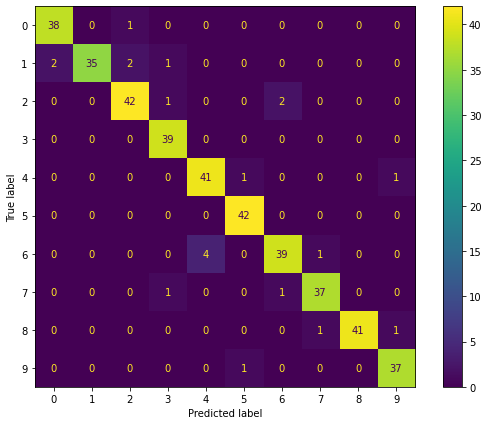

In [ ]:
plot_confusion(preds, y_test)

## Teste com a ResNet-50

ResNet é um acrônimo para Residual Networks, é uma rede neural usada como base para muitas aplicações de visão computacional. Uma Rede Neural Residual é uma Rede Neural Artificial de um tipo que empilha blocos residuais uns sobre os outros para formar uma rede. A ResNet foi introduzida pela primeira vez por Kaiming He, Xiangyu Zhang, Shaoqing Ren e Jian Sun em um trabalho de uma pesquisa de visão computacional de 2015 intitulado “Deep Residual Learning for Image Recognition”. A ResNet possui várias variantes que mudam, basicamente, o número de camadas entre elas e a que iremos usar é a ResNet-50, que pode trabalhar com 50 camadas.

Para podermos usar a ResNet50, da biblioteca Keras, para fins de comparação com a rede proposta, primeiro precisamos fazer um fine-tuning para que ela se adapte as nossas imagens. Como a rede é pré treinada e, portanto, não podemos mudar os formatos de entrada, é necessário criar outro dataset, sem deixar as imagens em escala de cinza, pois é esperado imagens com 3 canais. O processo é o mesmo feito anteiormente, utilizando as mesmas funções, com a diferença de que passamos um valor que indique que precisamos das imagens originais.

Mais informações sobre a ResNet: <br>
https://viso.ai/deep-learning/resnet-residual-neural-network/ 

In [ ]:
resnet_images, resnet_labels = get_images("drive/MyDrive/TP3 - AM/Dataset", False)
resnet_X_train, resnet_X_test, resnet_y_train, resnet_y_test = train_test_split(resnet_images, 
            resnet_labels, random_state=1, test_size=0.4, stratify=resnet_labels)

resnet_X_validation = resnet_X_test[412:].copy()
resnet_y_validation = resnet_y_test[412:].copy()

resnet_X_test = resnet_X_test[:412].copy()
resnet_y_test = resnet_y_test[:412].copy()

convert_labels_onehot(resnet_y_train)
convert_labels_onehot(resnet_y_validation)

resnet_X_train = np.array(resnet_X_train)
resnet_y_train = np.array(resnet_y_train) 

resnet_X_validation = np.array(resnet_X_validation)
resnet_y_validation = np.array(resnet_y_validation) 

resnet_X_test = np.array(resnet_X_test)

Na célula abaixo carregamos o modelo pré treinado e colocamos, como entrada, uma camada que recebe uma entrada de 100x100x3. É importante lembrar que, como iremos fazer o fine-tuning, não incluímos a rede totalmente conectada Como a rede já está treinada, temos que bloquear o treinamento das camadas já carregadas, pois o treinamento irá ocorrer apenas nas camadas que adicionaremos, estas que irão aprender a classificar os dados de entrada.

In [ ]:
input = keras.layers.Input(shape=(100, 100, 3))
baseModel = keras.applications.ResNet50(weights="imagenet", include_top=False,
                                input_tensor=input, input_shape=(100, 100, 3))

for layer in baseModel.layers[:]:
   layer.trainable = False

print(baseModel.summary())

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

As camadas adicionadas são as mesmas que foram utilizadas na rede proposta, isso foi feito desta maneira para que apenas as partes convolucionais fossem diferentes, podendo permitir uma melhor comparação entre os resultados. É interessante notar que, no final, estamos comparando um modelo de mais de 50 camadas, contanto com a parte adicionada, com um que possui pouco menos de 20.

In [ ]:
model = keras.models.Sequential()
model.add(baseModel)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=64))

model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(units=64))
model.add(keras.layers.Dropout(.2))

model.add(keras.layers.Dense(units=16))
model.add(keras.layers.Dropout(.2))

model.add(keras.layers.Dense(units=16))
model.add(keras.layers.Dense(units=10, activation=keras.activations.softmax))

In [ ]:
loss_fn = keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
print("model compiled")
print(model.summary())

model compiled
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16)  

Durante os testes foi observado que utilizar mais de 3 épocas gera um overfitting, visto que a acurácia da validação começa a cair enquanto a acurácia do treino continua a subir. Isso nos mostra a grande capacidade que é gerada ao se utilizar 50 camadas e, como não possuimos tantos dados, a melhor escolha é parar o fine-tunning de forma precoce.

In [ ]:
validation_data = (resnet_X_validation, resnet_y_validation)
history = model.fit(x=resnet_X_train, y=resnet_y_train, epochs=3, batch_size=25, validation_data=validation_data, verbose=1)

Epoch 1/3
50/50 [==============================] - 61s 1s/step - loss: 55.8563 - accuracy: 0.4356 - val_loss: 9.5035 - val_accuracy: 0.7427
Epoch 2/3
50/50 [==============================] - 58s 1s/step - loss: 11.0885 - accuracy: 0.7344 - val_loss: 4.3059 - val_accuracy: 0.8398
Epoch 3/3
50/50 [==============================] - 56s 1s/step - loss: 6.4147 - accuracy: 0.7951 - val_loss: 2.5753 - val_accuracy: 0.8738


Como podemos observar abaixo, a ResNet-50 não foi tão bem quanto a rede proposta anteriormente. Assim como na rede proposta, o sinal equivalente ao número 5 obteve 100% de precisão na maior parte dos testes, reforçando que possivelmente é o sinal mais fácil de ser identificado corretamente. Diferente da primeira, que possuia baixas precisões para os sinais 1 e 6, a ResNet-50 apresentou acurácias baixas para 6, 7 e 8, confundindo bastante os três entre eles, como veremos adiante na matriz de confusão.

A acurácia apontada durante os testes ficou em torno de 88%, se mostrando tão eficiente quanto um SVM polinomial. Isso nos leva a crer que a rede proposta é um "sucesso", visto que resolve melhor o problema com menos capacidade.

In [ ]:
preds = model.predict(resnet_X_test)
preds = [convert_onehot_labels(p) for p in preds]
print(classification_report(resnet_y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.92      0.94      0.93        35
           2       0.93      0.87      0.90        45
           3       1.00      0.93      0.96        42
           4       0.77      0.91      0.84        45
           5       1.00      0.98      0.99        44
           6       0.81      0.71      0.76        42
           7       0.62      0.77      0.69        39
           8       0.71      0.71      0.71        41
           9       0.97      0.82      0.89        39

    accuracy                           0.86       412
   macro avg       0.87      0.86      0.87       412
weighted avg       0.87      0.86      0.87       412



Como dito anteriormente, foi observado que a ResNet-50 confunde bastante os sinais de 7 e 8, e isso é visível com a matriz de confusão abaixo. É interessante notar que esses dois sinais em específico são confundidos muito entre eles, mas também com quase todos os outros. Por este motivo que ambos possuem revocação tão baixas, e os demais possuem revocações mais baixas do que a da rede proposta.

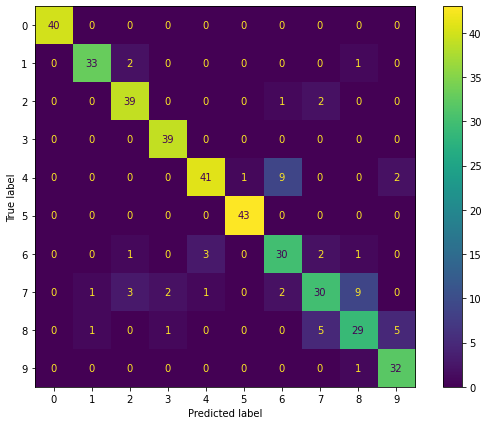

In [ ]:
plot_confusion(preds, resnet_y_test)

# Conclusão


Neste trabalho foram testados diferentes algoritmos de classificação no conunto de representações dos dígitos de 0 a 9 da American Sign Language, que possui cerca de 2000 imagens 100x100x3 e está disponível na plataforma GitHub e Kaggle. Foram testados os métodos tradicionais, como Naive Bayes e KNN, foi criada uma rede convolucional e também foi utilizada a ResNet-50 com fine-tunning para que se adaptasse aos nossos dados. 

Para cada tipo de teste foi necessário fazer uma transformação na entrada. Para os métodos tradicionais, foi necessário passar as imagens, que já estavam em escala de cinza e normalizadas, por um extrator de features, que gerava conjuntos de 4356 featues para cada imagem apresentada. Já para a rede convolucional proposta, as imagens foram transformadas para escala de cinza, para baratear todo o processo, e foram normalizadas com valores de 0 a 1, para evitar erros de precisão numérica. Para a ResNet-50 não foram feitas nenhuma modificações, visto que a rede esperava imagens com três canais de cores.

Dos métodos tradicionais o que se saiu melhor foi o SVM com kernel polinomial, mas os valores atingidos variam muito conforme mudamos os parâmetros do extrator de features. Com este fato em mente, fica o questionamento se poderíamos atingir melhores resultados utilizando um outro conjunto de features que não foi testado. Os testes referentes a ResNet-50 mostraram que a quantidade de dados que estávamos utilizando era pequena demais para sua alta capacidade, devida a seus mais de 25.6 milhões de parâmetros, gerando overfitting nas primeiras partes do treinamento, tendo acurácias menores do que o SVM com kernel polinomial.

Nos testes da rede convolucional proposta, foi observado que ela atingia acurácias superiores a 92% na maioria dos casos, chegando a 96%. É interessante salientar que a rede proposta foi criada do 0, tendo como base a experimentação, onde tudo foi definido empiricamente, juntando o conhecimento adquirido ao longo da matéria com a parte prática, desde quais camadas usar, até as taxas de dropout. A rede possui cerca de 1.2 milhão de parâmetros, se mostrando 25 vezes menor do que a ResNet-50 em termos de parâmetros.

Tendo tudo isso em retrospecto, podemos concluir que obtivemos sucesso na criação de um classificador para o problema proposto, chegando em acurácias satisfatórias com uma rede relativamente pequena. Também foi interessante notar o poder dos algoritmos tradicionais juntamente a um extrator de features, gerando valores de acurácias iniciais interessantes.